<center style="font-size: 2em; font-weight: bold;"> Retornos a la Educacion </center>
<center style="font-size: 2em; font-weight: bold;"> Analisis de base de datos  </center>
<left style="font-size: 4em; font-weight: bold;"> Autor: Edinson Tolentino </left>

# Librerias

In [1]:
import pandas
import numpy
import os
import sys
import numpy

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

import sklearn
import sklearn.compose
#import category_encoders
import sklearn.impute

from plotnine import *
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

#import py_hep_functions
import seaborn
import matplotlib.pyplot as plt

In [2]:

color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]

def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = numpy.finfo("float").eps

    return [
        round(x, round_n) for x in list(numpy.arange(start, stop + (by - epsilon), by))
    ]
    
def normalize_frame(frame):
    """Normalize the data frame to make it performant and compatible with
    downstream libraries such as Scikit-Learn and CatBoost.
    
    In particular the following operations are performed:
    - Categorical levels that are not strings are converted into strings
    - Categorical missing values are converted into a distinct "N/A" level
    - Object-typed columns are converted into categorical columns
    """
    for col, series in frame.items():
        dtype = series.dtype
        if pandas.api.types.is_categorical_dtype(dtype):
            recode = False
            if series.hasnans:
                recode = True
            else:
                for value in series.cat.categories:
                    if not isinstance(value, str):
                        recode = True
                        break
            if recode:
                frame[col] = series.astype("str").fillna("N/A").astype(
                    "category")
        elif pandas.api.types.is_object_dtype(dtype):
            frame[col] = series.astype("str").fillna("N/A").astype("category")

    return frame

base_transformer = sklearn.pipeline.Pipeline([
    ("recode", sklearn.compose.ColumnTransformer(transformers=[
        ("category",
             #sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore",
             sklearn.preprocessing.OneHotEncoder(drop="first",handle_unknown="ignore",                                                 
                min_frequency=0.01, max_categories=30, sparse_output= False),
             sklearn.compose.make_column_selector(dtype_exclude=numpy.number)
        ),
        ("number",
            sklearn.impute.SimpleImputer(strategy="mean"),
            sklearn.compose.make_column_selector(dtype_include=numpy.number)
        ),  
    ], n_jobs=-1)),
    #("rescale", sklearn.preprocessing.StandardScaler()),
])

# Analisis

In [3]:
output           = "C:/Users/et396/Dropbox/Docencia/UNI/202501/S1/Aplicacion"
os.chdir(output)

# Carga de data
base = pandas.read_stata("Mincer_2021.dta")


In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24774 entries, 0 to 24773
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         24774 non-null  int32   
 1   rcod_persona  24774 non-null  object  
 2   rcod_hogar    24774 non-null  object  
 3   rmujer        24774 non-null  int32   
 4   r6            24774 non-null  float64 
 5   lnr6          24774 non-null  float64 
 6   rmu           24774 non-null  int32   
 7   rneduca       24774 non-null  category
 8   r3            24774 non-null  int32   
 9   redad         24774 non-null  int32   
 10  redadsq       24774 non-null  int32   
 11  rDpto         24774 non-null  object  
 12  rpareja       24774 non-null  int32   
 13  reduca        24774 non-null  float64 
 14  rpobre        24774 non-null  int32   
 15  rmiembro      24774 non-null  int32   
 16  rgasto        24774 non-null  float64 
dtypes: category(1), float64(4), int32(9), object(3)
me

In [5]:
# Filtro de variables
response = ['lnr6']
inputs = ['reduca', 'rmujer','redad','redadsq','rmiembro', 'rpareja', 'rDpto']
data_analysis = base[response + inputs]

# Normalise informacion : number, category columns
data_fit = normalize_frame(data_analysis)
data_fit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24774 entries, 0 to 24773
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lnr6      24774 non-null  float64 
 1   reduca    24774 non-null  float64 
 2   rmujer    24774 non-null  int32   
 3   redad     24774 non-null  int32   
 4   redadsq   24774 non-null  int32   
 5   rmiembro  24774 non-null  int32   
 6   rpareja   24774 non-null  int32   
 7   rDpto     24774 non-null  category
dtypes: category(1), float64(2), int32(5)
memory usage: 896.0 KB


C:\Users\et396\AppData\Local\Temp\ipykernel_14516\2308428612.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
C:\Users\et396\AppData\Local\Temp\ipykernel_14516\2308428612.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Introduction

In [6]:
data_fit.describe()

,lnr6,reduca,rmujer,redad,redadsq,rmiembro,rpareja
count,24774.000000,24774.000000,24774.000000,24774.000000,24774.000000,24774.000000,24774.000000
mean,6.709960,8.698151,0.283119,46.796763,2330.710866,3.533907,0.657221
std,1.348821,5.497429,0.450523,11.865056,1108.981603,1.718011,0.474648
min,0.000000,0.000000,0.000000,18.000000,324.000000,1.000000,0.000000
25%,6.204558,4.000000,0.000000,38.000000,1444.000000,2.000000,0.000000
50%,6.903789,11.000000,0.000000,47.000000,2209.000000,3.000000,1.000000
75%,7.474169,12.000000,1.000000,56.000000,3136.000000,5.000000,1.000000
max,10.860215,18.000000,1.000000,69.000000,4761.000000,15.000000,1.000000


In [7]:
data_fit.groupby("rmujer").agg(
    mean_productivity=("lnr6", "mean"), max=("lnr6", "max")
)

,mean_productivity,max
rmujer,,
0,6.843544,10.860215
1,6.371713,10.170463


In [8]:
frame = data_fit.groupby("rDpto").agg(
    mean_wage=("lnr6", "mean"), mean_reduca=("reduca", "mean")
)


C:\Users\et396\AppData\Local\Temp\ipykernel_14516\1815886142.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


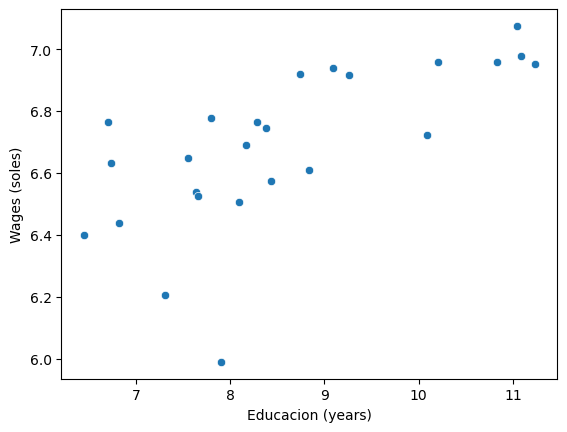

In [9]:
fig1 = seaborn.scatterplot(frame,
                           x='mean_reduca',
                           y='mean_wage',
                          )
fig1.set(xlabel='Educacion (years)', ylabel='Wages (soles)')
plt.show()

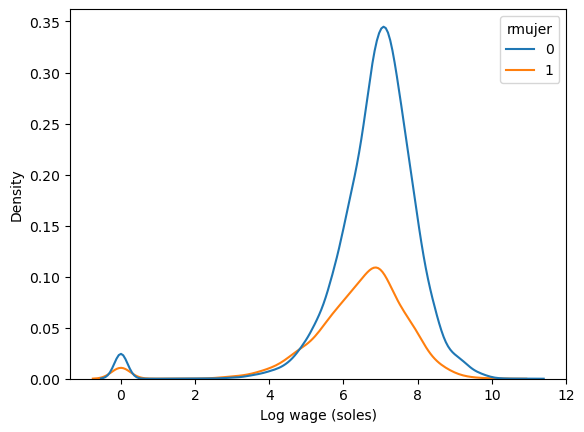

In [10]:
fig2 = seaborn.kdeplot(data_fit, 
                x='lnr6', hue='rmujer')
fig2.set(xlabel='Log wage (soles)', ylabel='Density')
plt.show()

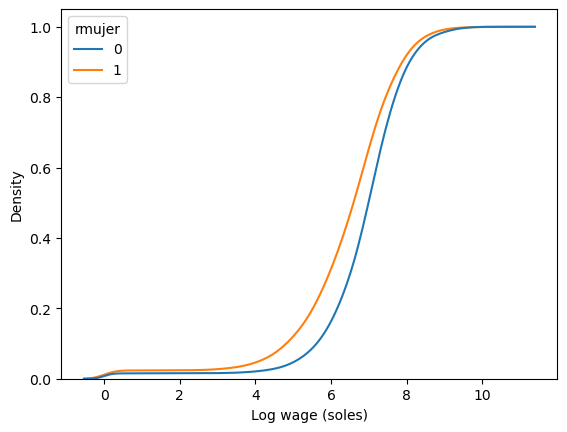

In [11]:
fig3 = seaborn.kdeplot(
    data=data_fit, x="lnr6", hue="rmujer",
    cumulative=True, common_norm=False, common_grid=True,
)
fig3.set(xlabel='Log wage (soles)', ylabel='Density')
plt.show()


In [12]:
# Define the bins for age groups
bins = [0, 20, 25, 30, 35, 40, 45, 50, float('inf')]  # Including infinity for the last bin

# Define labels for the age groups
labels = ["<20", "20-25", "25-30", "30-35", "35-40", "40-45", "45-50","50-55"]

# Create a new column 'group_redad' based on the age groups
data_fit['redad_group'] = pandas.cut(data_fit['redad'], bins=bins, labels=labels, right=False)

frame_inicial = data_fit.groupby(["redad_group","rmujer"]).agg(
    awage=("lnr6", "mean")
).reset_index()
frame_inicial

C:\Users\et396\AppData\Local\Temp\ipykernel_14516\8670372.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\et396\AppData\Local\Temp\ipykernel_14516\8670372.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,redad_group,rmujer,awage
0,<20,0,6.519410
1,<20,1,6.388425
2,20-25,0,6.849284
3,20-25,1,6.128145
4,25-30,0,6.904754
5,25-30,1,6.275025
6,30-35,0,6.933387
7,30-35,1,6.350780
8,35-40,0,7.004982
9,35-40,1,6.456529


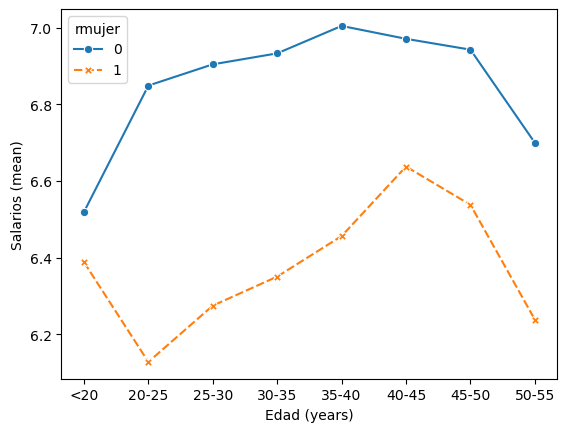

In [13]:
# Seleccion de comando seaborn
fig4 = seaborn.lineplot(frame_inicial, 
                 x='redad_group', y='awage', 
                 hue='rmujer',style="rmujer",
                 markers=True, dashes=True
                )
fig4.set(xlabel='Edad (years)', ylabel='Salarios (mean)')
plt.show()

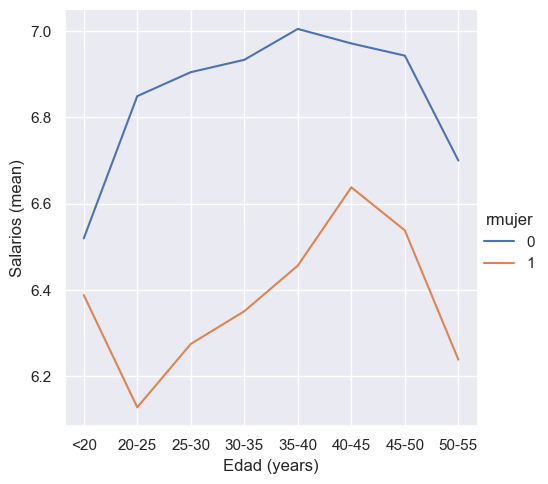

In [14]:
seaborn.set_theme(style="darkgrid")
fig5 = seaborn.relplot(frame_inicial, 
                 x='redad_group', y='awage', 
                 hue='rmujer',
                 dashes=False,
                 markers=True,   
                 kind="line"
                )
fig5.set(xlabel='Edad (years)', ylabel='Salarios (mean)')
plt.show()


# Question 1

## Modelos Lineales

In [15]:
response = data_fit[['lnr6']]

In [16]:
predictors_cols1 = ['reduca']
predictors_cols2 = ['reduca', 'rmujer','redad','redadsq', 'rpareja']
predictors_cols3 = ['reduca', 'rmujer','redad','redadsq', 'rpareja','rDpto']


In [17]:
base1        = data_fit[predictors_cols1]
predictors  = data_fit[predictors_cols1]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base1.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m1 = sm.OLS( response, inputs).fit(cov_type="HC1")

In [18]:
base2        = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols2]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base2.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m2 = sm.OLS( response, inputs).fit(cov_type="HC1")

In [19]:
base3        = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols3]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base3.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m3 = sm.OLS( response, inputs).fit(cov_type="HC1")

In [20]:
stargazer = Stargazer([m1, m2, m3])
stargazer.custom_columns(["ln wage", "ln wage", "ln wage"], [1, 1, 1])
stargazer.covariate_order(["number__reduca", 'number__rmujer', "number__redad", "number__redadsq","number__rpareja"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Efectos fijos Dpto", ["", "", "Yes"])
stargazer

In [21]:
# Exportar resultados
os.chdir(output)
file_name = "resumen_lineal.tex" #Inclusion de archivo en tex
tex_file = open( file_name, "w" ) #archivos 
tex_file.write( stargazer.render_latex() )
tex_file.close()

file_name = "resumen_lineal.html" #Inclusion de archivo html
tex_file = open( file_name, "w" ) #archivos
tex_file.write( stargazer.render_html() )
tex_file.close()



In [22]:
base3        = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols3]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base3.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m4 = sm.OLS( response, inputs).fit()

In [23]:
stargazer = Stargazer([m3, m4])
stargazer.custom_columns([ "ln wage", "ln wage"], [ 1, 1])
stargazer.covariate_order(["number__reduca"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Controles", ["", "Yes"])
stargazer.add_line("Efectos fijos Dpto", ["", "Yes"])
stargazer

C:\Users\et396\AppData\Local\Temp\ipykernel_14516\265103416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\et396\AppData\Local\Temp\ipykernel_14516\265103416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\et396\AppData\Local\Temp\ipykernel_14516\265103416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

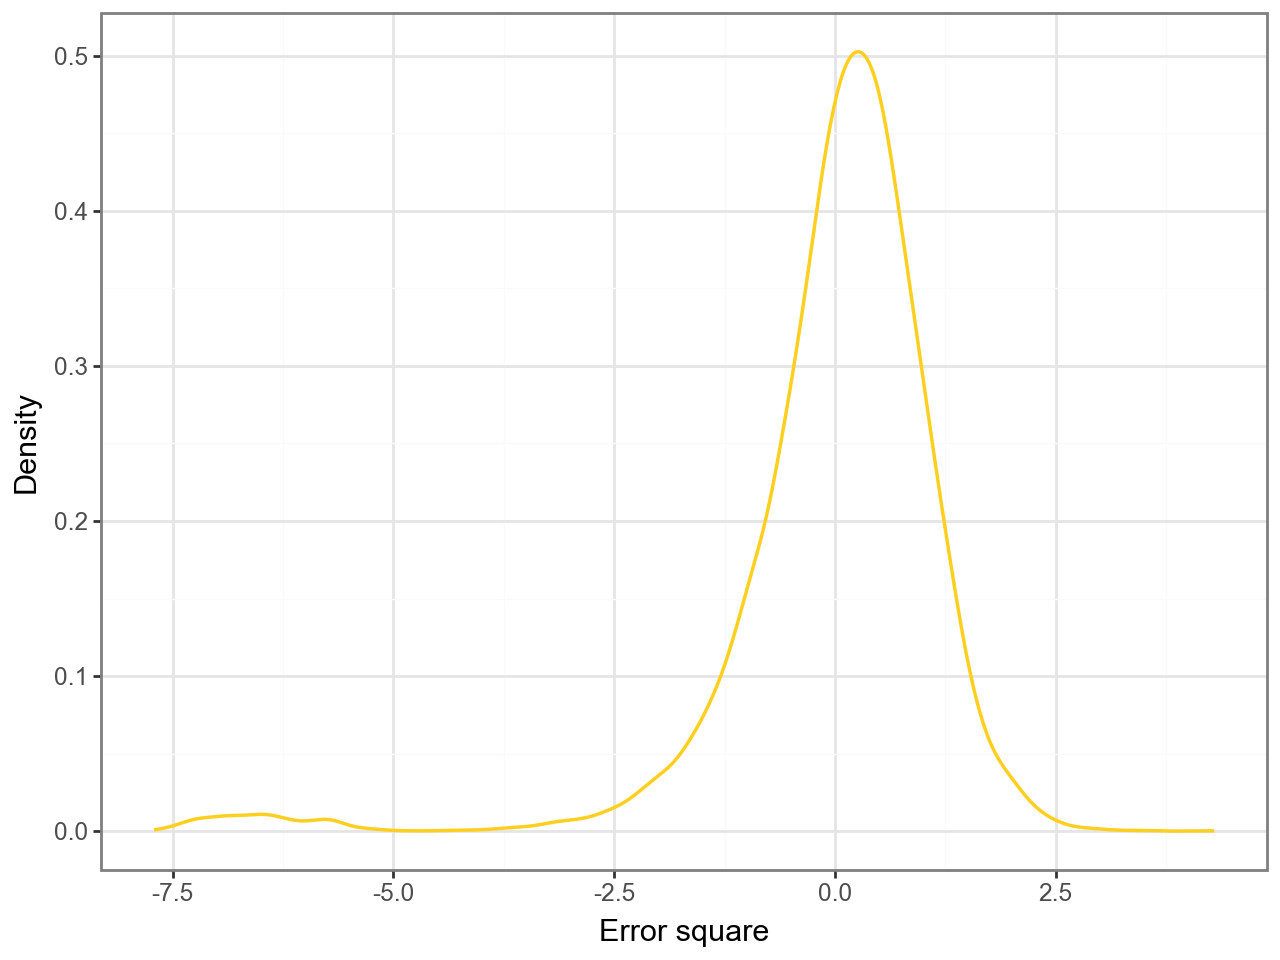

In [24]:
# Error 
data_fit["rerror"] = m4.resid
data_fit["rerror"] = data_fit["rerror"].astype('float')
data_fit["rerrorsq"] = data_fit["rerror"]**2
data_fit["rerrorsq"].head()

# Grafico de histograma
(
    ggplot(data_fit, aes(x='rerror', y ='stat(density)')) 
    + geom_density(adjust= 1.5, show_legend=False, na_rm=True, size = 0.7, color=color[3])
    + labs(x='Error square', y='Density')
    + theme_bw()
)


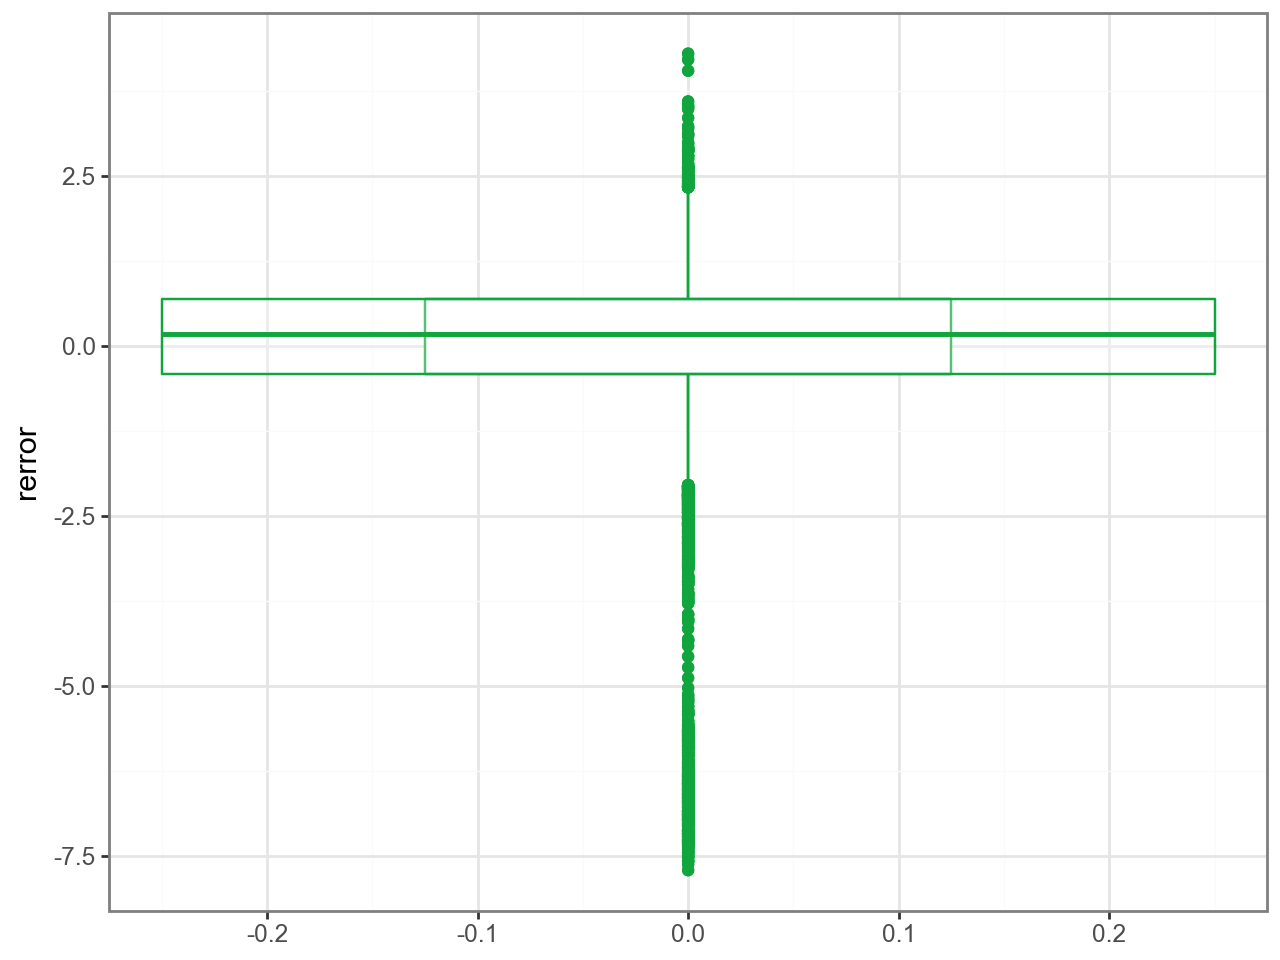

In [25]:
# Grafico de Caja 
(
 ggplot(data_fit, aes(y='rerror'))
 + stat_boxplot( width=0.25, size=0.5, color=color[1] , na_rm=False)
 + geom_boxplot( size= 0.5, width=0.5, color=color[1] , alpha = 0.3)
 #+ geom_jitter(aes(color="rerrorsq"), position=position_jitter(0.1), size=0.5, show_legend=False)   
 #+ scale_y_continuous(expand=[0.01, 0.01], limits=[-8, 3], breaks=seq(-8, 3, 0.75))   
 + theme_bw()
)

In [26]:
uhat = data_fit[["rerrorsq"]]

In [27]:
base3        = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols3]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base3.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

# Estimacion del modelo
m4_c = sm.OLS( uhat, inputs).fit()


# Presentacion de resultados
stargazer = Stargazer([ m4_c])
stargazer.custom_columns([ "ln wage"], [ 1])
stargazer.covariate_order(["number__reduca", 'number__rmujer', "number__redad", "number__redadsq","number__rpareja"])
stargazer.rename_covariates({"Intercept": "Constant"})
#stargazer.add_line("Controles", [ "Yes"])
stargazer.add_line("Efectos fijos Dpto", [ "Yes"])
stargazer


# Question 2

In [28]:
predictors_cols2 = ['reduca', 'redad','redadsq', 'rpareja',  'rmujer']

base2        = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols2]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base2.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m2r = sm.OLS( response, inputs).fit(cov_type="HC3")

In [29]:
stargazer = Stargazer([m1, m2r])
stargazer.custom_columns([ "ln wage", "ln wage"], [ 1, 1])
stargazer.covariate_order(["number__reduca", 'number__rmujer', "number__redad", "number__redadsq","number__rpareja"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Controles", ["", "Yes"])
stargazer.add_line("Efectos fijos Dpto", ["", "No"])
stargazer

### Matrix de varianzas y covarianzas

In [30]:
# Matriz de variance y covarianza
mvc_1 =  m2r.cov_params()
mvc_1


,const,number__reduca,number__redad,number__redadsq,number__rpareja,number__rmujer
const,0.013013,-2.402059e-05,-5.645074e-04,5.932636e-06,-1.540595e-04,-1.582626e-04
number__reduca,-0.000024,2.054646e-06,1.616414e-07,-1.177084e-10,2.651235e-07,-2.327241e-06
number__redad,-0.000565,1.616414e-07,2.624336e-05,-2.825713e-07,-1.116894e-05,-9.625690e-06
number__redadsq,0.000006,-1.177084e-10,-2.825713e-07,3.101463e-09,1.259932e-07,1.027347e-07
number__rpareja,-0.000154,2.651235e-07,-1.116894e-05,1.259932e-07,4.887264e-04,3.905126e-04
number__rmujer,-0.000158,-2.327241e-06,-9.625690e-06,1.027347e-07,3.905126e-04,6.490593e-04


In [31]:
# Mesuaring the inverse of matrix
# First to measure is matrix covarianve and varieance
matrix_1 = numpy.array(mvc_1)
print(matrix_1.shape)

# select specific variable of the matrix and apply inverse
print(matrix_1[4:6,4:6])
matrix_inv = numpy.linalg.inv(matrix_1[4:6,4:6])

# Print result of matrix
print(matrix_inv)
print(matrix_inv.shape)

(6, 6)
[[0.00048873 0.00039051]
 [0.00039051 0.00064906]]
[[ 3940.56286299 -2370.8765199 ]
 [-2370.8765199   2967.15137059]]
(2, 2)


In [32]:
# metodo wald
# Multiplication across each matrix
betas_ho = numpy.array( [[m2r.params['number__rmujer'] , m2r.params['number__rpareja']]])
print(betas_ho)
print(betas_ho.shape)

[[-0.56016566 -0.13403529]]
(1, 2)


In [33]:
betas_transpose = betas_ho.T
print(betas_transpose)
print(betas_transpose.shape)

[[-0.56016566]
 [-0.13403529]]
(2, 1)


In [34]:
multiplication_1 = numpy.dot(betas_ho, matrix_inv)
multiplication_1

array([[-1889.58686145,   930.38060971]])

In [35]:
wald = numpy.dot(multiplication_1, betas_transpose)
print(wald)
wald_test = float(wald)
#wald_test = wald.astype('float')
print(wald_test)

# EL valor de la distribucion de chi-cuadrado con dos grados de libertad sera: 5.99
# https://datatab.es/tutorial/chi-square-distribution

[[933.7778298]]
933.7778297965675


C:\Users\et396\AppData\Local\Temp\ipykernel_14516\3430163067.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


# Question 3

### Relacion no lineal edad

In [36]:
# Cual es la edad donde los ingresos de los individuos se reduce
-(m2r.params['number__redad'] / (2*m2r.params['number__redadsq']) )
edad_optima = round(-(m2r.params['number__redad'] / (2*m2r.params['number__redadsq']) ),0)
edad_optima

43.0

In [37]:
data_fit['reduca'].describe()

count    24774.000000
mean         8.698151
std          5.497429
min          0.000000
25%          4.000000
50%         11.000000
75%         12.000000
max         18.000000
Name: reduca, dtype: float64

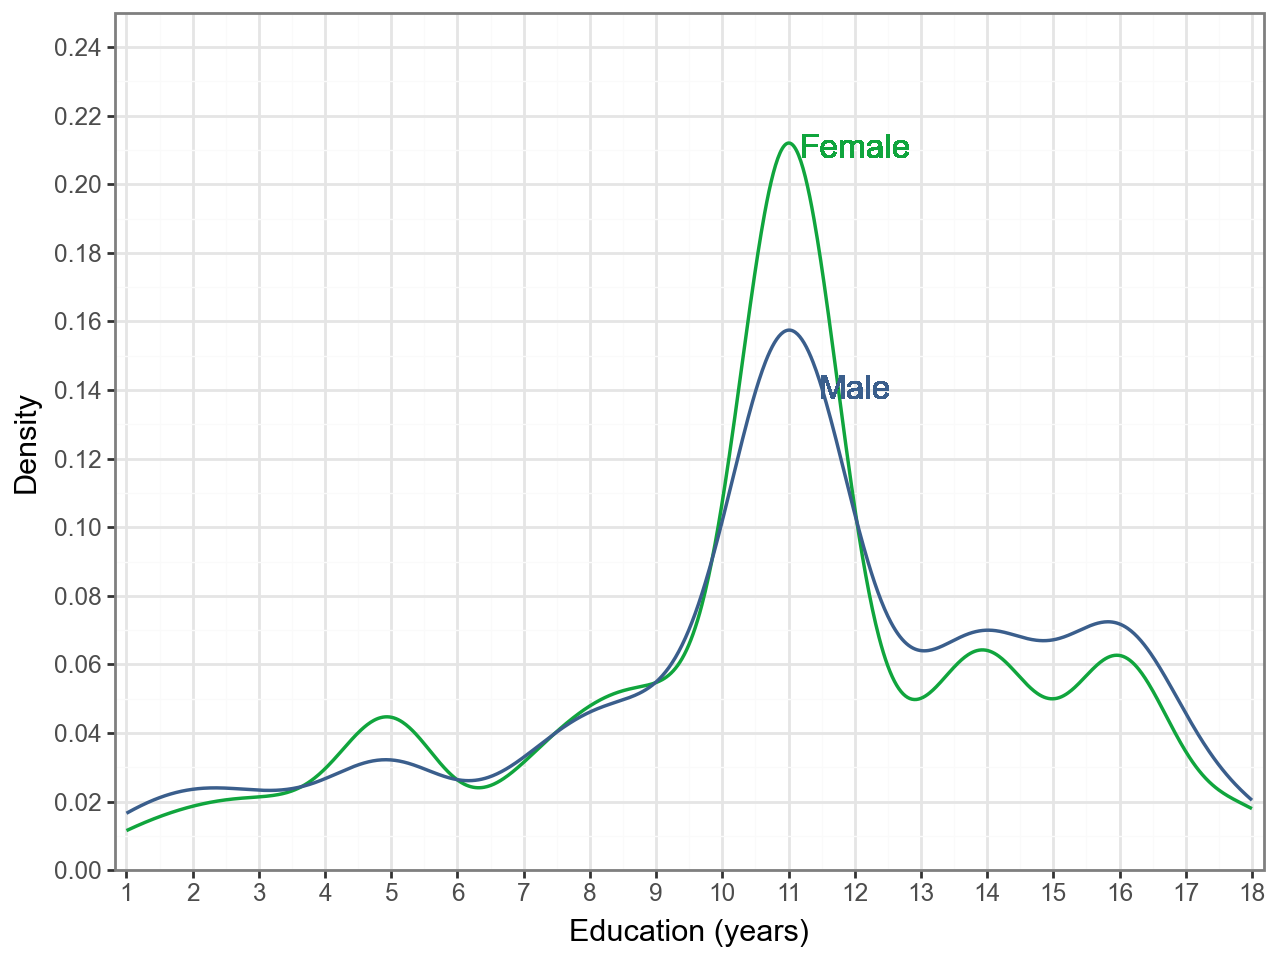

In [38]:
(
    ggplot(data_fit, aes(x="reduca", y="stat(density)", color="factor(rmujer)"))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="Education (years)", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Female", "Male")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 18), breaks=seq(1, 18, by=1))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.25), breaks=seq(0, 0.25, by=0.02)
    )
    + geom_text(aes(x=12, y=0.21, label="'Female'"), color=color[1], size=12)
    + geom_text(aes(x=12, y=0.14, label="'Male'"), color=color[0], size=12)
    + theme_bw()
)

In [ ]:
(
    ggplot(data_fit, aes(x="redad", y="stat(density)", color="factor(rmujer)"))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="Age (years)", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Female", "Male")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(18, 65), breaks=seq(18, 65, by=4))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.05), breaks=seq(0, 0.05, by=0.01)
    )
    + geom_text(aes(x=55, y=0.025, label="'Female'"), color=color[1], size=12)
    + geom_text(aes(x=55, y=0.03, label="'Male'"), color=color[0], size=12)
    + theme_bw()
)

### Metodo Delta

In [ ]:
# Matriz de variance y covarianza
mvc_table =  m2r.cov_params()
mvc_table


In [ ]:
beta2 = m2r.params['number__redad']
beta3 = m2r.params['number__redadsq']

In [ ]:
delta_beta2=-(1/ (2*beta3))
delta_beta2

In [ ]:
delta_beta3 =(beta2/ ((2*(beta3**2))))
delta_beta3

In [ ]:
#mvc_matrix[3,3]
mvc_matrix[2,2]

In [ ]:
# Change MVC to matrix
# Change to matrix
mvc_matrix = mvc_table.to_numpy()

# squre derivada
delta_beta2sq = delta_beta2**2
delta_beta3sq = delta_beta3**2

# variance of beta2 
var_beta2      = mvc_matrix[2,2]
var_beta3      = mvc_matrix[3,3]
cov_beta2_beta3= mvc_matrix[2,3]


# Delta Metodo
delta = (delta_beta2sq*var_beta2) + (delta_beta3sq*var_beta3) + (2*delta_beta2*delta_beta3*cov_beta2_beta3)
delta


# Question 4

### Split data (Mujer vs hombre)

In [ ]:
predictors_cols2 = ['reduca', 'redad','redadsq', 'rpareja']

In [ ]:
data_fit_m = data_fit.query("rmujer==0") # male
data_fit_f = data_fit.query("rmujer==1") # female


In [ ]:
data_fit_m.shape

In [ ]:
base2       = data_fit_m[predictors_cols2]
predictors  = data_fit_m[predictors_cols2]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base2.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

response_m = data_fit_m[['lnr6']]
m2r_m = sm.OLS( response_m, inputs).fit(cov_type="HC1")


In [ ]:
base2       = data_fit_f[predictors_cols2]
predictors  = data_fit_f[predictors_cols2]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base2.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

response_f = data_fit_f[['lnr6']]
m2r_f = sm.OLS( response_f, inputs).fit(cov_type="HC1")


In [ ]:
stargazer = Stargazer([m2r, m2r_m, m2r_f])
stargazer.custom_columns([ "All", "Male", "Female"], [ 1, 1, 1 ])
stargazer.covariate_order(["number__reduca","number__rmujer"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Controles", ["Yes", "Yes" ,"Yes"])
stargazer.add_line("Efectos fijos Dpto", ["No", "No", "No"])
stargazer

### Interaction

In [ ]:
data_fit['i1'] = data_fit['rmujer']* data_fit['reduca']  
predictors_cols2 = ['reduca',"rmujer" ,'i1', 'redad','redadsq', 'rpareja']

base2       = data_fit[predictors_cols2]
predictors  = data_fit[predictors_cols2]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=base2.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

m2r_iter = sm.OLS( response, inputs).fit(cov_type="HC1")



In [ ]:
stargazer = Stargazer([m2r, m2r_m, m2r_f, m2r_iter])
stargazer.custom_columns([ "All", "Male", "Female", "Interaction"], [ 1, 1, 1, 1 ])
stargazer.covariate_order(["number__reduca","number__rmujer", "number__i1"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Controles", ["Yes", "Yes" ,"Yes", "Yes"])
stargazer.add_line("Efectos fijos Dpto", ["No", "No", "No", "Mo"])
stargazer